# 1- Hello Friends

Hello Future Engineers, Nice to meet you!
First we import our libraries that will we need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import glob as gb
import cv2
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

# 2- Data
Make 3 variables for 3 bathes of datasets: train, test and predict.

In [2]:
train = '../input/intel-image-classification/seg_train/seg_train'
test  = '../input/intel-image-classification/seg_test/seg_test'
pred  = '../input/intel-image-classification/seg_pred/seg_pred'

# 3- Size
I make the size of images, batch size and epoches as a variable to be easy to control it in all of the model.
> Prefer to make the number of batch size 2 power n like (8,16,32,64,128,...), the weill increase the processing.

In [3]:
size  = 128
batch = 128
epochs = 100

# 4- Data Augmentation
Make data augmentation on train and test datasets and imprt them from pathes.

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             width_shift_range=.2, height_shift_range=.2,
                             rotation_range=30,
                             brightness_range=[0.8, 1.2],
                             horizontal_flip=True)

In [5]:
X_train = datagen.flow_from_directory(directory=train, target_size=(size,size), batch_size=batch, shuffle=True,)

Found 14034 images belonging to 6 classes.


In [6]:
X_test = ImageDataGenerator(rescale=1/255).flow_from_directory(directory=test, target_size=(size,size), batch_size=batch, shuffle=True,)

Found 3000 images belonging to 6 classes.


Number of images in Prediction Data:

In [7]:
X_test.class_indices.keys()

dict_keys(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [8]:
files = gb.glob(pathname= str(pred + '/*.jpg'))
print(f'For Prediction data, found {len(files)}')

For Prediction data, found 7301


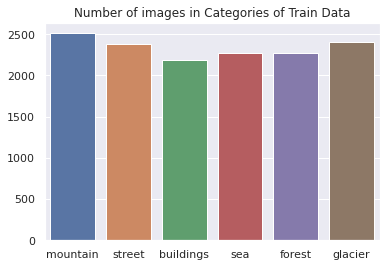

In [42]:
train_data_size = {}

for folder in  os.listdir(train) : 
    files = gb.glob(pathname= str(train +'/' + folder + '/*.jpg'))
    train_data_size[folder] = len(files)

classes = list(train_data_size.keys())
train_no_imgs = [train_data_size[i] for i in classes]

sns.barplot(classes, train_no_imgs)
plt.title("Number of images in Categories of Train Data")
plt.show()

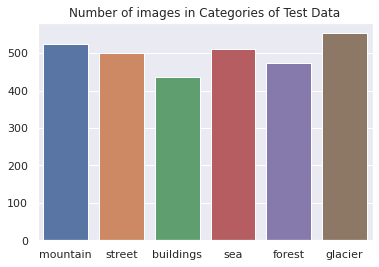

In [10]:
test_data_size = {}

for folder in  os.listdir(test) : 
    files = gb.glob(pathname= str(test +'/' + folder + '/*.jpg'))
    test_data_size[folder] = len(files)

test_no_imgs = [test_data_size[i] for i in classes]

sns.barplot(classes, test_no_imgs)
plt.title("Number of images in Categories of Test Data")
plt.show()

# 5- Setup Callbacks

In [11]:
checkpoint_filepath = 'best_model.hdf5'
best_model = 'BestModel.hdf5'
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.003, patience=30)
callback_learningrate = ReduceLROnPlateau(monitor='val_accuracy', mode='max', min_delta=0.003, patience=10, factor=0.5, min_lr=0.00001)

callbacks = [callback_checkpoint, callback_earlystopping, callback_learningrate]

# 6- Design CNN and NN

In [12]:
Model =tf.keras.models.Sequential([ tf.keras.layers.Conv2D(256,kernel_size=(3,3),activation='relu',input_shape=(size,size,3)),
                                    tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(4,4),

                                    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),    
                                    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(3,3),

                                    tf.keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu', padding = 'Same'),
                                    tf.keras.layers.Conv2D(8,kernel_size=(3,3),activation='relu', padding = 'Same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2,2),

                                    tf.keras.layers.Flatten() ,
                                    tf.keras.layers.Dense(256,activation='relu'),
                                    tf.keras.layers.Dropout(rate=0.4), 
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dropout(rate=0.3),
                                    tf.keras.layers.Dense(64,activation='relu'),
                                    tf.keras.layers.Dropout(rate=0.2),
                                    tf.keras.layers.Dense(32,activation='relu') ,
                                    tf.keras.layers.Dropout(rate=0.1),            
                                    tf.keras.layers.Dense(16,activation='relu') ,
                                    tf.keras.layers.Dropout(rate=0.05),
                                    tf.keras.layers.Dense(8,activation='relu') ,
                                    tf.keras.layers.Dropout(rate=0.02),
                                    tf.keras.layers.Dense(6,activation='softmax')])


Model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(Model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 256)     7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 128)     295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 32)        1

# 7- Train the Model

In [13]:
history = Model.fit(x=X_train, validation_data=X_test, epochs=epochs, verbose=2, callbacks=callbacks)

Epoch 1/100
110/110 - 195s - loss: 1.6452 - accuracy: 0.2642 - val_loss: 1.7631 - val_accuracy: 0.2553
Epoch 2/100
110/110 - 82s - loss: 1.3304 - accuracy: 0.4063 - val_loss: 1.4136 - val_accuracy: 0.4413
Epoch 3/100
110/110 - 81s - loss: 1.2063 - accuracy: 0.5011 - val_loss: 1.0851 - val_accuracy: 0.5773
Epoch 4/100
110/110 - 81s - loss: 1.0959 - accuracy: 0.5576 - val_loss: 0.9509 - val_accuracy: 0.6347
Epoch 5/100
110/110 - 83s - loss: 1.0305 - accuracy: 0.5963 - val_loss: 1.2766 - val_accuracy: 0.5120
Epoch 6/100
110/110 - 82s - loss: 0.9705 - accuracy: 0.6380 - val_loss: 0.9822 - val_accuracy: 0.6323
Epoch 7/100
110/110 - 81s - loss: 0.9253 - accuracy: 0.6687 - val_loss: 1.0527 - val_accuracy: 0.5970
Epoch 8/100
110/110 - 81s - loss: 0.8558 - accuracy: 0.6976 - val_loss: 1.0450 - val_accuracy: 0.6337
Epoch 9/100
110/110 - 81s - loss: 0.8205 - accuracy: 0.7161 - val_loss: 0.7337 - val_accuracy: 0.7427
Epoch 10/100
110/110 - 81s - loss: 0.7849 - accuracy: 0.7299 - val_loss: 0.8193 -

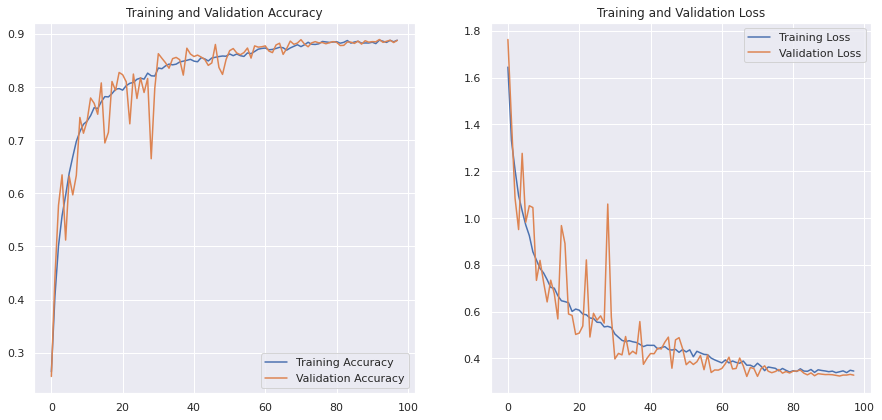

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(98)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 8- Load Best Model

In [17]:
Best_Model = tf.keras.models.load_model('best_model.hdf5')
#Best_Model.summary()

> This line of code is very important because the order of classes of that the model has trained on it differes from the order oc classes that get from directory.

In [43]:
print("Old Classes:", classes)
classes = list(X_train.class_indices.keys())
print("New Classes:", classes)

Old Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
New Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


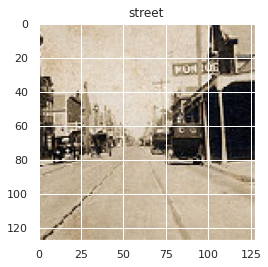

In [44]:
file = pred + "/14.jpg"
image = tf.keras.preprocessing.image.load_img(path=file, target_size=(size, size))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
y_pred = Model.predict(input_arr)
label = classes[np.argmax(y_pred)]

plt.imshow(image)
plt.title(label)
plt.show()

# 9- GUI Version
You can use GUI version of the model and download the best model from [Github](https://github.com/abdelrahmanzied/Intel_image_Classification).